<a href="https://colab.research.google.com/github/AndresInsuasty/tesis-cafes-especiales/blob/main/pix2pix_vs_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook para comparar resultados de algoritmo Pix2Pix y autoencoder

## Librerias

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import random

## Rutas

In [3]:
# Ruta raiz
PATH = "/content/drive/MyDrive/segmentado/dataset2"

# Ruta de datos de entrada
INPATH = PATH + '/ndvi/'
# Ruta de salida
OUTPATH = PATH + '/labels/'
# Ruta de los checkpoints
CKPATH = PATH + '/chechpoints'

# Ruta modelo Pix2pix
p2p ='/content/drive/MyDrive/segmentado/pix2pix/pix2pixmodel20211030.h5'
p2p_b = '/content/drive/MyDrive/segmentado/pix2pix/pix2pixmodelbandas20211103-30.h5'

# Ruta modelo Autoencoder
auc ='/content/drive/MyDrive/segmentado/pix2pix/autoencoder20211030.h5'
auc_b = '/content/drive/MyDrive/segmentado/pix2pix/autoencodermodelbandas20211105.h5'

# Lista de imagenes
imgurls = !ls -1 "{INPATH}"

## Organizando dataset

In [4]:
#random.seed(10)
#random.shuffle(imgurls)
n = len(imgurls)
train_n = round(n*0.8)

# Particion Train/Test
tr_urls = imgurls[:train_n]
ts_urls = imgurls[train_n:n]
print('El tamaño total del dataset es {} \n Entrenamiento: {} \n Testeo: {} '.format(len(imgurls),len(tr_urls),len(ts_urls)))

El tamaño total del dataset es 3210 
 Entrenamiento: 2568 
 Testeo: 642 


In [48]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
# Reescalar imagenes
def resize(inimg,tgimg, height,width):
    inimg = tf.image.resize(inimg,[height,width])
    tgimg = tf.image.resize(tgimg,[height,width])

    return inimg,tgimg

# Normalizar el rango [-1, +1] la imagen
def normalize(inimg,tgimg,model='p2p'):
    if model=='p2p' or model=='p2pb':
        inimg = (inimg/127.5)-1
        tgimg = (tgimg/127.5)-1
    else:
        inimg = (inimg/255)
        tgimg = (tgimg/255)

    return inimg,tgimg

def random_jitter(inimg,tgimg):
    inimg,tgimg = resize(inimg,tgimg,286,286)

    stacked_image = tf.stack([inimg,tgimg],axis=0)
    croppped_image = tf.image.random_crop(stacked_image,size=[2,IMG_WIDTH,IMG_HEIGHT,3])

    inimg,tgimg = croppped_image[0], croppped_image[1]

    if tf.random.uniform(())>0.5:
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)

    return inimg,tgimg

def load_image(filename, augment=False,banda=False,modelo='p2p'):
    b1_name=tf.strings.regex_replace(filename, "ndvi", "b1")
    b2_name=tf.strings.regex_replace(filename, "ndvi", "b2")
    b3_name=tf.strings.regex_replace(filename, "ndvi", "b3")
    b4_name=tf.strings.regex_replace(filename, "ndvi", "b4")
    tg_name=tf.strings.regex_replace(filename, "ndvi", "label")
    banda_path = INPATH.replace('ndvi','bandas')    


    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)),tf.float32)
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + tg_name)),tf.float32)
    b1 = tf.cast(tf.image.decode_jpeg(tf.io.read_file(banda_path + '/' + b1_name)),tf.float32)[...,0:1]
    b2 = tf.cast(tf.image.decode_jpeg(tf.io.read_file(banda_path + '/' + b2_name)),tf.float32)[...,0:1]
    b3 = tf.cast(tf.image.decode_jpeg(tf.io.read_file(banda_path + '/' + b3_name)),tf.float32)[...,0:1]
    b4 = tf.cast(tf.image.decode_jpeg(tf.io.read_file(banda_path + '/' + b4_name)),tf.float32)[...,0:1]

    inimg, tgimg = resize(inimg, tgimg, IMG_WIDTH, IMG_HEIGHT)
    
    # if augment:
    #     inimg,tgimg = random_jitter(inimg,tgimg)
    if banda==True:
        inimg = tf.concat([b1,b2,b3,b4],2)
        inimg,tgimg = normalize(inimg,tgimg,model=modelo)
    else:
        inimg,tgimg = normalize(inimg,tgimg,model=modelo)
    return inimg,tgimg

## Cargar modelos

In [49]:
try:
    p2p_model = load_model(p2p)
    p2pb_model = load_model(p2p_b)
    auc_model = load_model(auc)
    aucb_model = load_model(auc_b)
    print('modelos cargados exitosamente')
except:
    print('No fue posible cargar los modelos')

modelos cargados exitosamente


## Prueba de carga

In [58]:
def auc_predict(i,banda=False, model='auc'):
    entrada,etiqueta = load_image(ts_urls[i],banda=banda,modelo='auc')
    if model=='auc':
        aux=np.zeros([1,256,256,3])
    if model=='aucb':
        aux=np.zeros([1,256,256,4])
    salida2 = np.zeros([1,256,256,3])
    aux[0,...]=entrada
    if model=='auc':
        pred_salida = auc_model.predict(aux)
    if model=='aucb':
        pred_salida = aucb_model.predict(aux)
    salida2 = pred_salida
    return salida2
def p2p_predict(i,banda=False,model='p2p'):
    entrada,etiqueta =load_image(ts_urls[i],banda=banda,modelo=model)
    if model=='p2p':
        aux=np.zeros([1,256,256,3])
    if model=='p2pb':
        aux=np.zeros([1,256,256,4])
    salida2 = np.zeros([1,256,256,3])
    aux[0,...]=entrada # el modelo necesita una entrada de 4 dimensiones (examples,rows,columns,caps)
    if model=='p2p':
        salida = p2p_model(aux,training=True)
    if model=='p2pb':
        salida = p2pb_model(aux,training=True)
    salida2[...,0] = salida[...,0]
    salida2[...,1] = salida[...,1]
    salida2[...,2] = salida[...,2]
    return salida2

In [59]:
imagen = 500
entrada,salida = load_image(ts_urls[imagen],augment=False,modelo='auc')
auc_p = auc_predict(imagen,banda=False,model='auc')
aucb_p = auc_predict(imagen,banda=True,model='aucb')

p2p_p = p2p_predict(imagen,banda=False,model='p2p')
p2pb_p = p2p_predict(imagen,banda=True,model='p2pb')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


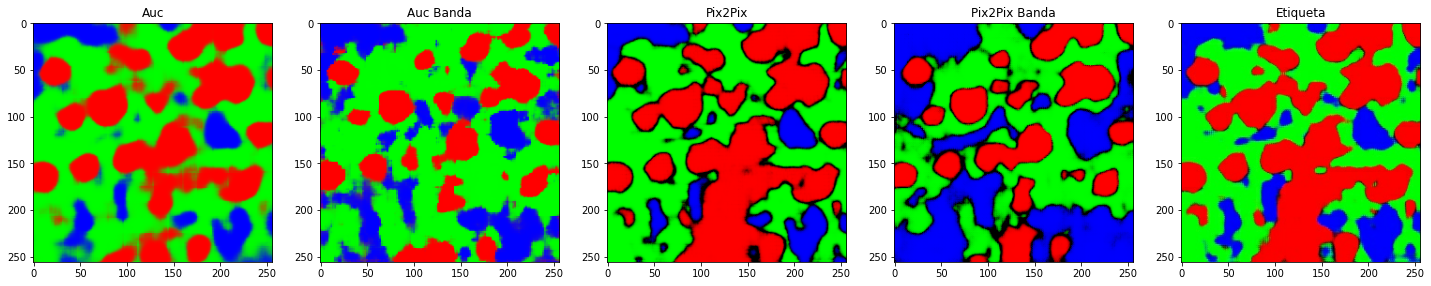

In [63]:
plt.figure(figsize=(30,12))

plt.subplot(161)
plt.title('Auc')
plt.imshow(np.squeeze(auc_p))

plt.subplot(162)
plt.title('Auc Banda')
plt.imshow(np.squeeze(aucb_p))

plt.subplot(163)
plt.title('Pix2Pix')
plt.imshow(np.squeeze(p2p_p))

plt.subplot(164)
plt.title('Pix2Pix Banda')
plt.imshow(np.squeeze(p2pb_p))

plt.subplot(165)
plt.title('Etiqueta')
plt.imshow(np.squeeze(salida))
plt.show()



## Metricas de desempeño

### Actualizar libreria para metricas

In [64]:
!pip install -U scikit-image

     |████████████████████████████████| 29.2 MB 1.6 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [65]:
from skimage import metrics

### Funciones para calcular medidas

In [66]:
def calcular_metricas_auc(original,pred):
    label = original[0,...]
    label = np.around(label)
    #label = pred[0,...]
    test = pred[0,...]
    #ct = metrics.contingency_table(label,test)
    #hd = metrics.hausdorff_distance(label,test)
    #hp = metrics.hausdorff_pair(label,test)
    mse = metrics.mean_squared_error(label,test)
    #nrm = metrics.normalized_root_mse(label,test)
    #psnr = metrics.peak_signal_noise_ratio(label,test)
    ss = metrics.structural_similarity(label,test, multichannel=True)
    return mse,ss
#calcular_metricas_auc(original=salida,pred=auc_p)


In [119]:
def calcular_metricas_p2p(original,pred):
    mse = metrics.mean_squared_error(np.squeeze(original),(np.squeeze(pred)+1)/2)
    ss = metrics.structural_similarity(np.squeeze(original),(np.squeeze(pred)+1)/2, multichannel=True)
    #ct = metrics.contingency_table(label,test)
    #hd = metrics.hausdorff_distance(label,test)
    #hp = metrics.hausdorff_pair(label,test)    
    #nrm = metrics.normalized_root_mse(np.squeeze(salida),np.squeeze(test))
    #psnr = metrics.peak_signal_noise_ratio(np.squeeze(salida),np.squeeze(test))
    
    return mse,ss
#calcular_metricas_p2p(original=salida,pred=p2p_p)

In [147]:
def contar_areas(img):
    if img.min()<0:
        img = (img+1)/2
    elif img.max()>10:
        img = img/255
    a = np.around(img)
    c0 = a[...,0]
    c1 = a[...,1]
    c2 = a[...,2]
    return np.sum(c0),np.sum(c1),np.sum(c2)

## Obteniendo métricas

In [165]:
mse_auc = []
ss_auc = []
c0_auc = []
c1_auc = []
c2_auc = []

mse_p2p = []
ss_p2p = []
c0_p2p = []
c1_p2p = []
c2_p2p = []

mse_p2pb = []
ss_p2pb = []
c0_p2pb = []
c1_p2pb = []
c2_p2pb = []

mse_aucb = []
ss_aucb = []
c0_aucb = []
c1_aucb = []
c2_aucb = []

for i in range(len(ts_urls)):
#for i in range(10):
    imagen = i
    entrada,salida = load_image(ts_urls[i],augment=False,modelo='auc')
    area_etiqueta = contar_areas(salida.numpy())

    # obtener estimaciones de modelos
    auc_p = auc_predict(imagen,banda=False,model='auc')
    aucb_p = auc_predict(imagen,banda=True,model='aucb')

    p2p_p = p2p_predict(imagen,banda=False,model='p2p')
    p2pb_p = p2p_predict(imagen,banda=True,model='p2pb')

    # Contar el area de las imagenes estimadas
    area_auc = contar_areas(auc_p[0,...])
    area_aucb = contar_areas(aucb_p[0,...])
    area_p2p = contar_areas(p2p_p[0,...])
    area_p2pb = contar_areas(p2pb_p[0,...])

    # Calcular metricas de similitud de imagenes
    mse1,ss1 = calcular_metricas_auc(salida,auc_p[0,...])
    mse2,ss2 = calcular_metricas_auc(salida,aucb_p[0,...])
    mse3,ss3 = calcular_metricas_p2p(salida,p2p_p)
    mse4,ss4 = calcular_metricas_p2p(salida,p2pb_p)

    aux = np.absolute(area_auc[0]-area_etiqueta[0])/(area_etiqueta[0]+1)
    if aux>1:
        aux = 1
    c0_auc.append(aux)
    aux = np.absolute(area_auc[1]-area_etiqueta[1])/(area_etiqueta[1]+1)
    if aux>1:
        aux = 1
    c1_auc.append(aux)
    aux = np.absolute(area_auc[2]-area_etiqueta[2])/(area_etiqueta[2]+1)
    if aux>1:
        aux = 1
    c2_auc.append(aux)

    aux = np.absolute(area_aucb[0]-area_etiqueta[0])/(area_etiqueta[0]+1)
    if aux>1:
        aux = 1
    c0_aucb.append(aux)
    aux = np.absolute(area_aucb[1]-area_etiqueta[1])/(area_etiqueta[1]+1)
    if aux>1:
        aux = 1
    c1_aucb.append(aux)
    aux = np.absolute(area_aucb[2]-area_etiqueta[2])/(area_etiqueta[2]+1)
    if aux>1:
        aux = 1
    c2_aucb.append(aux)



    aux = np.absolute(area_p2p[0]-area_etiqueta[0])/(area_etiqueta[0]+1)
    if aux>1:
        aux = 1
    c0_p2p.append(aux)
    aux = np.absolute(area_p2p[1]-area_etiqueta[1])/(area_etiqueta[1]+1)
    if aux>1:
        aux = 1
    c1_p2p.append(aux)
    aux = np.absolute(area_p2p[2]-area_etiqueta[2])/(area_etiqueta[2]+1)
    if aux>1:
        aux = 1
    c2_p2p.append(aux)

    aux = np.absolute(area_p2pb[0]-area_etiqueta[0])/(area_etiqueta[0]+1)
    if aux>1:
        aux = 1
    c0_p2pb.append(aux)
    aux = np.absolute(area_p2pb[1]-area_etiqueta[1])/(area_etiqueta[1]+1)
    if aux>1:
        aux = 1
    c1_p2pb.append(aux)
    aux = np.absolute(area_p2pb[2]-area_etiqueta[2])/(area_etiqueta[2]+1)
    if aux>1:
        aux = 1
    c2_p2pb.append(aux)

    mse_auc.append(mse1)
    ss_auc.append(ss1)
    mse_aucb.append(mse2)
    ss_aucb.append(ss2)
    mse_p2p.append(mse3)
    ss_p2p.append(ss3)
    mse_p2pb.append(mse4)
    ss_p2pb.append(ss4)


/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


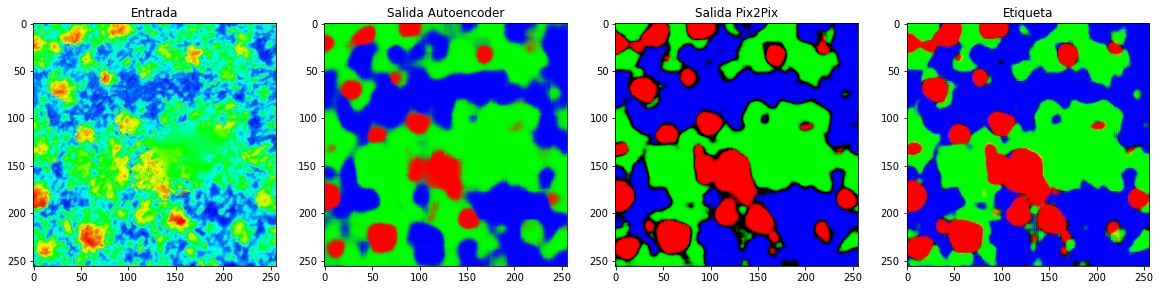

Error MSE:
  *AUC:0.287712339388434	P2P:0.2904795753338713	P2P_med:0.008901670754337601
Maximos:
  *AUC:0.9999998807907104	P2P:1.0	Label:1.0
Minimos:
  *AUC:4.540312570355809e-09	P2P:-1.0	Label:0.0
0.2904795753338713


/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


In [166]:
plt.figure(figsize=(20,12))

plt.subplot(141)
plt.title('Entrada')
plt.imshow(np.squeeze(entrada))

plt.subplot(142)
plt.title('Salida Autoencoder')
plt.imshow(np.squeeze(auc_p))

plt.subplot(143)
plt.title('Salida Pix2Pix')
plt.imshow(np.squeeze(p2p_p))

plt.subplot(144)
plt.title('Etiqueta')
plt.imshow(np.squeeze(salida))

plt.show()

mse2,ss2 = calcular_metricas_p2p(salida,p2p_p)
mse_auc_1 = metrics.mean_squared_error(np.squeeze(salida)/255,np.squeeze(auc_p))
mse_p2p_1 = metrics.mean_squared_error(np.squeeze(salida)/255,(np.squeeze(p2p_p)+1)/2)
ss_p2p_1 = mse_p2p_1 = metrics.mean_squared_error(np.squeeze(salida)/255,(np.squeeze(p2p_p)+1)/2)
print('Error MSE:\n  *AUC:{}\tP2P:{}\tP2P_med:{}'.format(mse_auc_1,mse_p2p_1,mse2))
print('Maximos:\n  *AUC:{}\tP2P:{}\tLabel:{}'.format(auc_p.max(),p2p_p.max(),np.max(entrada)))
print('Minimos:\n  *AUC:{}\tP2P:{}\tLabel:{}'.format(auc_p.min(),p2p_p.min(),np.min(entrada)))
print(ss_p2p_1)


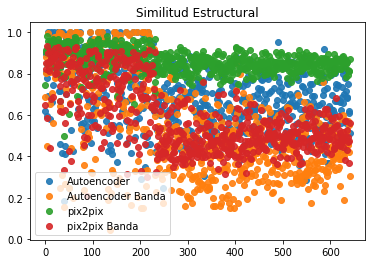

In [167]:
plt.scatter(range(len(ss_auc)),ss_auc,label='Autoencoder',alpha=0.9)
plt.scatter(range(len(ss_auc)),ss_aucb,label='Autoencoder Banda',alpha=0.9)
plt.scatter(range(len(ss_auc)),ss_p2p,label='pix2pix',alpha=0.9)
plt.scatter(range(len(ss_auc)),ss_p2pb,label='pix2pix Banda',alpha=0.9)

plt.legend()
plt.title('Similitud Estructural')
plt.show()

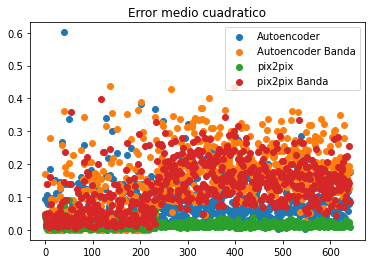

In [168]:
plt.scatter(range(len(ss_auc)),mse_auc,label='Autoencoder')
plt.scatter(range(len(ss_auc)),mse_aucb,label='Autoencoder Banda')
plt.scatter(range(len(ss_auc)),mse_p2p,label='pix2pix')
plt.scatter(range(len(ss_auc)),mse_p2pb,label='pix2pix Banda')

plt.legend()
plt.title('Error medio cuadratico')
plt.show()

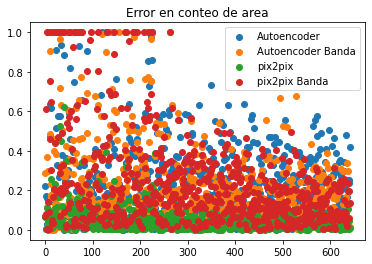

In [174]:
plt.scatter(range(len(ss_auc)),c1_auc,label='Autoencoder')
plt.scatter(range(len(ss_auc)),c1_aucb,label='Autoencoder Banda')
plt.scatter(range(len(ss_auc)),c1_p2p,label='pix2pix')
plt.scatter(range(len(ss_auc)),c1_p2pb,label='pix2pix Banda')

plt.legend()
plt.title('Error en conteo de area')
plt.show()

In [170]:
print('*'*50)
print('AUTOENCODER ACIERTO MEDIO EN EL CONTEO DE AREAS:')
print('\tArea Baja (azul):{}'.format(1-np.mean(c0_auc)))
print('\tArea Media (verde):{}'.format(1-np.mean(c1_auc)))
print('\tArea Alta (Roja):{}'.format(1-np.mean(c2_auc)))
print('Promedio de acierto:{}'.format( (1-np.mean(c0_auc)+1-np.mean(c1_auc)+1-np.mean(c2_auc))/3 ))
print('*'*50)

**************************************************
AUTOENCODER ACIERTO MEDIO EN EL CONTEO DE AREAS:
	Area Baja (azul):0.8525231478032854
	Area Media (verde):0.7735734802209275
	Area Alta (Roja):0.5727146324423733
Promedio de acierto:0.7329370868221954
**************************************************


In [171]:
print('*'*50)
print('AUTOENCODER BANDA ACIERTO MEDIO EN EL CONTEO DE AREAS:')
print('\tArea Baja (azul):{}'.format(1-np.mean(c0_aucb)))
print('\tArea Media (verde):{}'.format(1-np.mean(c1_aucb)))
print('\tArea Alta (Roja):{}'.format(1-np.mean(c2_aucb)))
print('Promedio de acierto:{}'.format( (1-np.mean(c0_aucb)+1-np.mean(c1_aucb)+1-np.mean(c2_aucb))/3 ))
print('*'*50)

**************************************************
AUTOENCODER BANDA ACIERTO MEDIO EN EL CONTEO DE AREAS:
	Area Baja (azul):0.6842827741035442
	Area Media (verde):0.800946022431274
	Area Alta (Roja):0.29564484364861454
Promedio de acierto:0.593624546727811
**************************************************


In [172]:
print('*'*50)
print('Pix2Pix ACIERTO MEDIO EN EL CONTEO DE AREAS:')
print('\tArea Baja (azul):{}'.format(1-np.mean(c0_p2p)))
print('\tArea Media (verde):{}'.format(1-np.mean(c1_p2p)))
print('\tArea Alta (Roja):{}'.format(1-np.mean(c2_p2p)))
print('Promedio de acierto:{}'.format( (1-np.mean(c0_p2p)+1-np.mean(c1_p2p)+1-np.mean(c2_p2p))/3 ))
print('*'*50)

**************************************************
Pix2Pix ACIERTO MEDIO EN EL CONTEO DE AREAS:
	Area Baja (azul):0.9677542082440438
	Area Media (verde):0.9530424866724452
	Area Alta (Roja):0.684575785979807
Promedio de acierto:0.8684574936320987
**************************************************


In [173]:
print('*'*50)
print('Pix2Pix BANDA ACIERTO MEDIO EN EL CONTEO DE AREAS:')
print('\tArea Baja (azul):{}'.format(1-np.mean(c0_p2pb)))
print('\tArea Media (verde):{}'.format(1-np.mean(c1_p2pb)))
print('\tArea Alta (Roja):{}'.format(1-np.mean(c2_p2pb)))
print('Promedio de acierto:{}'.format( (1-np.mean(c0_p2pb)+1-np.mean(c1_p2pb)+1-np.mean(c2_p2pb))/3 ))
print('*'*50)

**************************************************
Pix2Pix BANDA ACIERTO MEDIO EN EL CONTEO DE AREAS:
	Area Baja (azul):0.7323876012455909
	Area Media (verde):0.749568797813831
	Area Alta (Roja):0.28407307311921337
Promedio de acierto:0.5886764907262118
**************************************************
